In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


In [ ]:
#### CH4 lifetime

In [ ]:
#### Relation to beta and gamma in C4MIP

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in reciprocal


(20.0, 99.0)

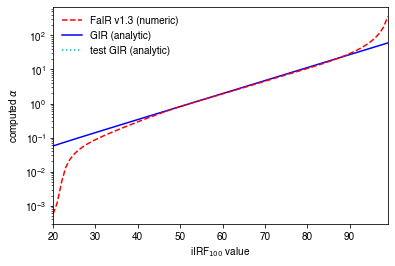

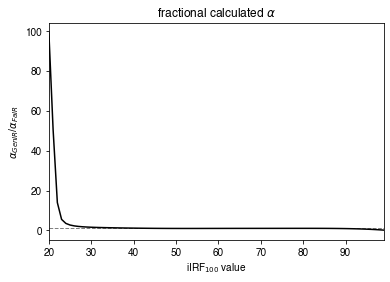

In [89]:
#### FaIRv2.0 vs v1.0 carbon cycle equations:

## Figure showing the comparison of the numerical vs analytic solution of the iIRF100:

gas_parameters = get_gas_parameter_defaults()

a = gas_parameters.loc['a1':'a4',('default','CO2')].values[np.newaxis,:]

tau = gas_parameters.loc['tau1':'tau4',('default','CO2')].values[np.newaxis,:]

def FaIR_alpha(alpha,iIRF,a,tau):
    
    return (iIRF - np.sum(a*alpha[:,np.newaxis]*tau*(1-np.exp(-100/(alpha[:,np.newaxis]*tau))),axis=-1))**2

def GIR_alpha(iIRF,a,tau):
    
    g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
    g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)
    
    return g0 * np.sinh( iIRF / g1 )

def test_GIR_alpha(iIRF,a,tau):
    
    F1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
    F2 = np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1)
    
    A = (np.exp(sp.optimize.root(lambda x: np.log(x)*x - F1/F2,x0=0).x))**-1
    B = (F2*np.log(1/A))**(-1)
    
    return A*np.exp(np.exp(B*iIRF))

def GIR_iIRF(alpha,a,tau):
    
    g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
    g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)
    
    return g1*np.arcsinh(alpha/g0)

iIRF_calc = np.arange(20,100)

FaIR_calc = sp.optimize.root(FaIR_alpha,np.full(iIRF_calc.size,1),args=(iIRF_calc,a,tau),method='lm').x

GenIR_calc = GIR_alpha(iIRF_calc,a,tau)
test_GenIR_calc = test_GIR_alpha(iIRF_calc,a,tau)

plt.semilogy(iIRF_calc,FaIR_calc,'r--',label='FaIR v1.3 (numeric)')
plt.semilogy(iIRF_calc,GenIR_calc,'b',label='GIR (analytic)',zorder=0)
plt.semilogy(iIRF_calc,test_GenIR_calc,'c:',label='test GIR (analytic)',zorder=10)
plt.xlabel('iIRF$_{100}$ value')
plt.ylabel(r'computed $\alpha$')
plt.legend()
plt.xlim(iIRF_calc[0],iIRF_calc[-1])

# plt.savefig('./Final_figures/iIRF100_numeric_analytic.pdf',bbox_inches='tight')

plt.figure()

plt.plot(iIRF_calc,GenIR_calc/FaIR_calc,'k')
plt.axhline(1,color='grey',linestyle='--',zorder=0,linewidth=1)
plt.title(r'fractional calculated $\alpha$')
plt.xlabel('iIRF$_{100}$ value')
plt.ylabel(r'$\alpha_{GenIR}$/$\alpha_{FaIR}$')
plt.xlim(iIRF_calc[0],iIRF_calc[-1])

In [312]:
B

1979637275.9211156

(20.0, 99.0)

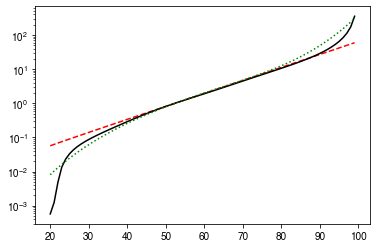

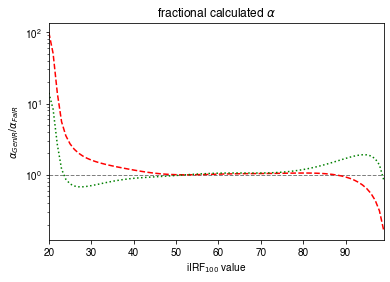

In [310]:
A = 5
B = 52.35430211**5/np.arcsinh(1/A)
GenIR_test = A*np.sinh((iIRF_calc)**5/B)

plt.semilogy(iIRF_calc,GenIR_calc,'r--')
plt.semilogy(iIRF_calc,FaIR_calc,'k')
plt.semilogy(iIRF_calc,GenIR_test,'g:')

plt.figure()

plt.semilogy(iIRF_calc,GenIR_calc/FaIR_calc,'r--')
plt.semilogy(iIRF_calc,GenIR_test/FaIR_calc,'g:')
plt.axhline(1,color='grey',linestyle='--',zorder=0,linewidth=1)
plt.title(r'fractional calculated $\alpha$')
plt.xlabel('iIRF$_{100}$ value')
plt.ylabel(r'$\alpha_{GenIR}$/$\alpha_{FaIR}$')
plt.xlim(iIRF_calc[0],iIRF_calc[-1])